In [1]:
import numpy as np
from tensorflow_probability import distributions as tfd
import tensorflow as tf

import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Prior probability of infection over time when meeting 1 contact

In [2]:
np.random.seed(41)
tf.random.set_seed(41)

# Start with prior (does not condition on current lack of symptoms)
minutes_in_a_day = 60*24
n_days = 14
n = n_days*minutes_in_a_day # Number of time steps (say each tick is a minute)
t = np.arange(0, n)
lam = 1e1
i_t = lam*tfd.Normal(loc=n-0.3*minutes_in_a_day,
                 scale=2.75*minutes_in_a_day).prob(t).numpy() # Infectiousness of contact at each time step

# Simulate interaction with a colleague during working hours
minute_of_the_day = np.mod(t, minutes_in_a_day)
work_hours_mask = (minute_of_the_day <= 60*17) & (60*9 <= minute_of_the_day)
x_t = 1. + (tfd.Normal(loc=0., scale=1.).sample(n).numpy())**2
x_t[~work_hours_mask] = np.inf

# Compute risk, probability of infection at each time step
g = lambda x: np.clip(1./x**2, a_min=0., a_max=1.)# Proximity risk function
r_t = i_t*g(x_t)
P_infected_at_time_t = 1. - np.exp(-r_t)# Prior for being infected at time t, P(I_t|\bar{I}_{t-1})
P_infected_by_time_t = 1. - np.cumprod(1 - P_infected_at_time_t)

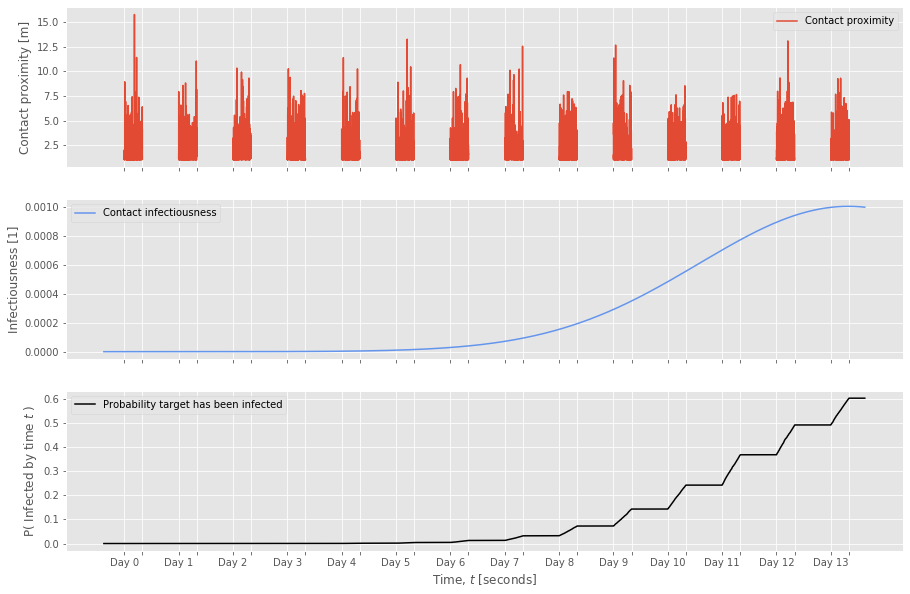

In [3]:
f, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 10), sharex=True)
work_day_xticks = np.hstack([minutes_in_a_day*np.arange(0, n_days) + 9*60.,
                             minutes_in_a_day*np.arange(0, n_days) + 17*60.])
axs[0].set_xticks(ticks=work_day_xticks)
axs[0].set_xticklabels(['Day ' + str(v) for v in range(0, n_days)])
axs[0].plot(x_t, label='Contact proximity'); 
axs[2].set_xlabel(r'Time, $t$ [seconds]'), axs[0].set_ylabel('Contact proximity [m]');
axs[1].plot(i_t, color='cornflowerblue', label='Contact infectiousness'); 
axs[1].set_ylabel('Infectiousness [1]');
axs[2].plot(P_infected_by_time_t, color='k', label='Probability target has been infected'); 
axs[2].set_ylabel(r'P( Infected by time $t$ )');
for ax in axs: ax.legend()

## Prior probability of infection over time when meeting 2 contacts

In [4]:
np.random.seed(41)
tf.random.set_seed(41)

# Start with prior (does not condition on current lack of symptoms)
minutes_in_a_day = 60*24
n_days = 14
n = n_days*minutes_in_a_day # Number of time steps (say each tick is a second)
t = np.arange(0, n)
lam = 1e1

# Contact 1 (colleague that reported infection today, now)
i1_t = lam*tfd.Normal(loc=n-0.3*minutes_in_a_day,
                 scale=2.75*minutes_in_a_day).prob(t).numpy()
minute_of_the_day = np.mod(t, minutes_in_a_day)
work_hours_mask = (minute_of_the_day <= 60*17) & (60*9 <= minute_of_the_day)
x1_t = 1. + (tfd.Normal(loc=0., scale=1.).sample(n).numpy())**2
x1_t[~work_hours_mask] = np.inf

# Contact 2 (close friend that reported infection 5 days ago)
i2_t = lam*tfd.Normal(loc=(n_days - 5.3)*minutes_in_a_day,
                 scale=2.75*minutes_in_a_day).prob(t).numpy()
pub_hours_mask = (minute_of_the_day <= 60*23) & (60*19 <= minute_of_the_day)
not_quarantined_mask = (t < 9*minutes_in_a_day)
x2_t = .5 + (tfd.Normal(loc=0., scale=.5).sample(n).numpy())**2
x2_t[~(pub_hours_mask & not_quarantined_mask)] = np.inf

# Compute risk, probability of infection at each time step
g = lambda x: np.clip(1./x**2, a_min=0., a_max=1.)# Proximity risk function
r1_t = i1_t*g(x1_t)
r2_t = i2_t*g(x2_t)
P_infected_by_t = 1. - np.exp(np.cumsum(-r1_t-r2_t)) # Expression in cumprod is P(\bar{I}_t|\bar{I}_{t-1})
P_infected_at_t = (1 - np.exp(-r1_t-r2_t))*(1. - P_infected_by_t) # Prior for being infected at time t, P(I_t, \bar{I}_{t-1})

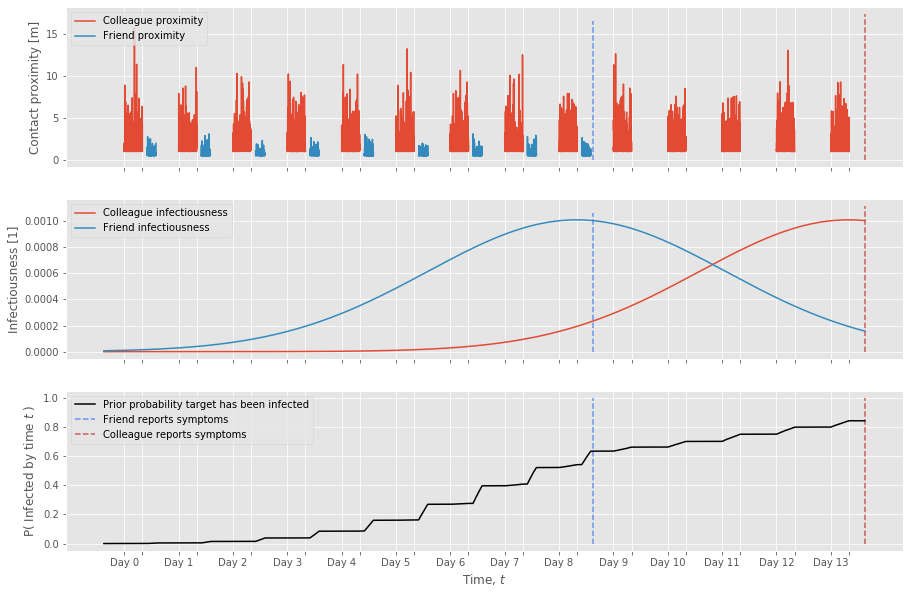

In [17]:
f, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 10), sharex=True)
work_day_xticks = np.hstack([minutes_in_a_day*np.arange(0, n_days) + 9*60.,
                            minutes_in_a_day*np.arange(0, n_days) + 17*60.])
axs[0].set_xticks(ticks=work_day_xticks)
axs[0].set_xticklabels(['Day ' + str(v) for v in range(0, n_days)])
axs[0].plot(x1_t, label='Colleague proximity'); 
axs[0].plot(x2_t, label='Friend proximity'); 
axs[0].set_ylabel('Contact proximity [m]');
axs[1].plot(i1_t, label='Colleague infectiousness'); 
axs[1].plot(i2_t, label='Friend infectiousness'); 
axs[1].set_ylabel('Infectiousness [1]')
axs[2].plot(P_infected_by_t, color='k', label='Prior probability target has been infected')
axs[2].set_ylabel(r'P( Infected by time $t$ )')
axs[2].set_xlabel(r'Time, $t$');
for ax in axs[0:2]:
    ax.vlines(x=(n_days-5.)*minutes_in_a_day, ymin=0, ymax=ax.get_ylim()[1],
              linestyle='--', color='cornflowerblue')
    ax.vlines(x=n, ymin=0, ymax=ax.get_ylim()[1], linestyle='--',
              color='indianred');
axs[2].vlines(x=(n_days-5.)*minutes_in_a_day, ymin=0, ymax=1., linestyle='--',
              color='cornflowerblue', label='Friend reports symptoms')
axs[2].vlines(x=n, ymin=0, ymax=1., linestyle='--', 
              color='indianred', label='Colleague reports symptoms');
for ax in axs: ax.legend(loc='upper left')

## Conditioning on user not having symptoms now (i.e. on day 14)

In [21]:
F_incub = lambda t: tfd.LogNormal(loc=1.6,
                                  scale=0.4).cdf(t/minutes_in_a_day).numpy()
P_no_symptoms_given_infected_at_t = 1. - F_incub(n - t) # P(\bar{S}_n|I_{t}, \bar{I}_{t-1})

In [10]:
def P_I_t_given_not_S(r, F_incub, t):
    '''
        r: one-dimensional np.array of n positive floats
        F_incub: Python function, incubation distribution cdf, units seconds
        t: non-negative int, index of timestep (should be <= n-1)
        
        NB dash ' denotes complement. 
        P_inf_at_j[t-1] is P_inf_at_t
        
        inf_by_j <=> I_j
        inf_at_j <=> I_j, I'_{j-1}
    '''
    n = len(r)
    j = np.arange(n) + 1
    
    # 1. Evaluate P(I'_t)
    P_inf_by_t = np.exp(-np.sum(r[0:t]))
    
    # 2. Compute P(I_j, I'_{j-1}) for j = 2, 3, ..., n
    P_inf_at_j = np.zeros(shape=n)
    P_inf_at_j[0] = 1. - np.exp(-r[0]) # Is P_infected_at_1
    P_inf_at_j[1:] = (1. - np.exp(-r[1:]))*np.exp(-np.cumsum(r[:-1]))
    
    # 3. Compute P(I'_n)
    P_not_inf_by_n = np.exp(-np.sum(r))
    
    # 4. Compute P(S'_n|I_j, I'_{j-1}) = 1 - F_incub(n - j)
    P_no_symp_given_inf_at_j = 1. - F_incub(n - j)
    
    # 5. Evaluate P(I_j, I'_{j-1}|I_t) = P(I_j, I'_{j-1})/P(I_t) for j = 1, ..., t
    P_inf_at_j_given_inf_by_t = P_inf_at_j[:t]/P_inf_by_t
    
    # 6. Evaluate P(I_j, I'_{j-1}|I'_t) = P(I_j, I'_{j-1})/P(I_t) for j = t+1, ..., n
    P_inf_at_j_given_not_inf_by_t = P_inf_at_j[t:]/(1. - P_inf_by_t)
    
    # 7. Compute P(S'_n, I_j, I'_{j-1}|I_t) and P(S'_n, I_j, I'_{j-1}|I'_t)
    P_no_symp_and_inf_at_j_given_inf_by_t = P_no_symp_given_inf_at_j[:t]*P_inf_at_j_given_inf_by_t
    P_no_symp_and_inf_at_j_given_not_inf_by_t = P_no_symp_given_inf_at_j[t:]*P_inf_at_j_given_not_inf_by_t
    
    # 7.5. Compute P(S'_n, I'_n|I'_t) = P(S'_n|I'_n)P(I'_n|I'_t) = 1*P(I'_n|I'_t)
    # NB P(I'_n|I'_t) = P(I'_n)/P(I'_t)
    P_no_symp_and_not_inf_by_n_given_not_inf_by_t = P_not_inf_by_n/(1. - P_inf_by_t)
    
    # 8. Evaluate P(S'_n|I_t) and P(S'_n|I'_t)
    P_no_symp_given_inf_by_t = np.sum(P_no_symp_and_inf_at_j_given_inf_by_t) 
    P_no_symp_given_not_inf_by_t = np.sum(P_no_symp_and_inf_at_j_given_not_inf_by_t) + \
                                   P_no_symp_and_not_inf_by_n_given_not_inf_by_t
    
    # 9. Compute P(S'_n) = P(S'_n|I_t)P(I_t) + P(S'_n|I'_t)P(I'_t)
    P_no_symp = P_no_symp_given_inf_by_t*P_inf_by_t + P_no_symp_given_not_inf_by_t*(1. - P_inf_by_t)
    
    # 10. Compute P(I_t|S'_n) = P(S'_n|I_t)P(I_t)/P(S'_n)
    P_inf_by_t_given_no_symp = P_no_symp_given_inf_by_t*P_inf_by_t/P_no_symp
    
    return(P_inf_by_t_given_no_symp)

In [11]:
# Need to write unit tests for this function

test_n = 10000
test_r = np.random.normal(loc=0., scale=.02, size=test_n)**2
test_t = 5000

# Unit test 1: LOTP test 1
P_I_t_given_not_S(test_r, F_incub, test_t) # Passed 20:04 on 10/06/20

0.7253249479170704

In [12]:
P_inf_by_t_given_no_symp = np.array([P_I_t_given_not_S(r_t, F_incub, t) for t in range(n)])

/Users/jw4518/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/jw4518/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/Users/jw4518/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide


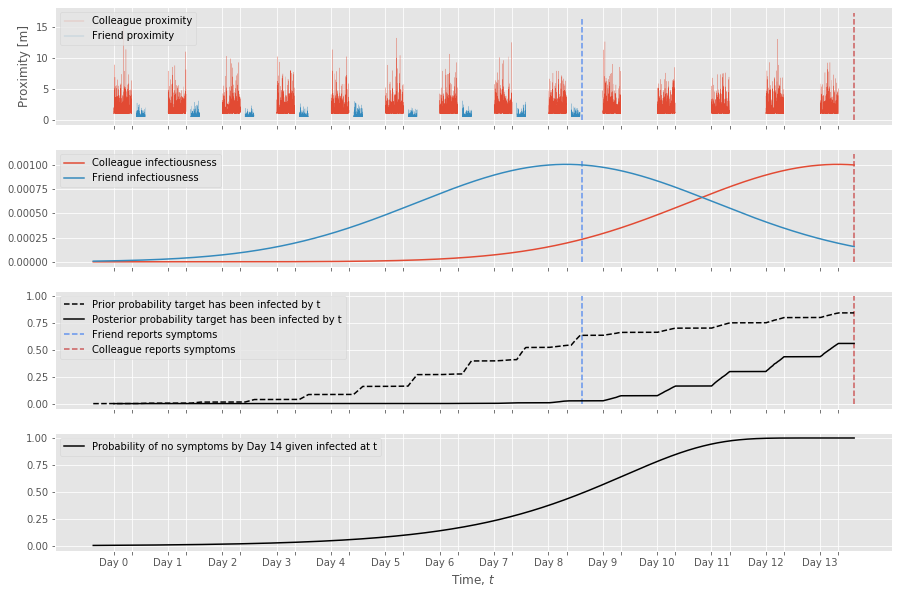

In [32]:
f, axs = plt.subplots(nrows=4, ncols=1, figsize=(15, 10), sharex=True)
work_day_xticks = np.hstack([minutes_in_a_day*np.arange(0, n_days) + 9*60.,
                            minutes_in_a_day*np.arange(0, n_days) + 17*60.])
axs[0].set_xticks(ticks=work_day_xticks)
axs[0].set_xticklabels(['Day ' + str(v) for v in range(0, n_days)])
axs[0].plot(x1_t, label='Colleague proximity', lw=0.2); 
axs[0].plot(x2_t, label='Friend proximity', lw=0.2); 
axs[0].set_ylabel('Proximity [m]');
axs[1].plot(i1_t, label='Colleague infectiousness'); 
axs[1].plot(i2_t, label='Friend infectiousness');
axs[2].plot(P_infected_by_t, color='k', linestyle='--',
            label='Prior probability target has been infected by t')
axs[2].plot(P_inf_by_t_given_no_symp, color='k',
            label='Posterior probability target has been infected by t')
axs[3].set_xlabel(r'Time, $t$');
axs[3].plot(P_no_symptoms_given_infected_at_t, color='k',
            label='Probability of no symptoms by Day 14 given infected at t')
for ax in axs[0:2]:
    ax.vlines(x=(n_days-5.)*minutes_in_a_day, ymin=0, ymax=ax.get_ylim()[1],
              linestyle='--', color='cornflowerblue')
    ax.vlines(x=n, ymin=0, ymax=ax.get_ylim()[1], linestyle='--',
              color='indianred');
axs[2].vlines(x=(n_days-5.)*minutes_in_a_day, ymin=0, ymax=1., linestyle='--',
              color='cornflowerblue', label='Friend reports symptoms')
axs[2].vlines(x=n, ymin=0, ymax=1., linestyle='--', 
              color='indianred', label='Colleague reports symptoms');
for ax in axs: ax.legend(loc='upper left')
plt.savefig('test.pdf', bbox_inches='tight')